# Language Estimation Analysis

This notebook presents the implementation of the `lang_confidence_score(word_counts, language_words_with_frequency)` function. This function estimates the likelihood that a given text originates from a specific language.

### Methodology

To evaluate the probability of a text belonging to a specific language, we establish a relationship between the word counts in the analyzed text and the reference word frequencies of the target language.

The proposed method compares the **relative frequencies** of words in the text ($P_{text}$) against the reference frequencies in the language ($P_{lang}$). Here, *relative frequency* represents the proportion of a specific word's occurrences relative to the total number of words.

The score is calculated as the **sum of the minimum relative frequencies for each word found in the intersection of both vocabularies**:

$$
Score(T,L) = \sum_{w\in T \cap L} \min(P_{text}(w), P_{lang}(w))
$$

Where:
* $T$ represents the set of words in the analyzed text.
* $L$ represents the set of words in the target language model.
* $P(w)$ represents the relative frequency of word $w$.

# Methodology implementation

In [ ]:
# necessary imports
import wordfreq
import os
from src.scraper_logic import WikiScraper
import matplotlib.pyplot as plt
import numpy as np

In [64]:
def lang_confidence_score(word_counts: dict, language_freqs: dict) -> float:
    # Normalize data from the text.
    total_text_count = sum(word_counts.values())
    if total_text_count == 0:
        return 0.0

    # Normalize data from the language.
    total_lang_freq = sum(language_freqs.values())
    if total_lang_freq == 0:
        return 0.0

    score = 0.0

    # Calculate intersection.
    for word, count in word_counts.items():
        if word in language_freqs:
            prob_text = count / total_text_count

            prob_lang = language_freqs[word] / total_lang_freq

            score += min(prob_text, prob_lang)

    return score

# Methodology testing

## Data Preparation

### Selected Texts

**1. Wiki Texts (Bulbapedia)**
* **Long Text:** "Ash Ketchum".
* **Short Text:** "Sun Flute".

**2. General Texts**
* **English (en):** "Pythonidae" (Wikipedia).
* **Polish (pl):** "Monty Python" (Wikipedia PL).
* **Italian (it):** "Pizza" (Wikipedia IT).

In [65]:
# Helper function to get word_dicts from articles.
def get_word_dict(lang: str, phrase: str, use_local_html_file_instead: bool):
    temp_scraper = WikiScraper(
        language=lang, use_local_html_file_instead=use_local_html_file_instead, base_path="./data/")
    temp_article = temp_scraper.scrape(phrase)
    res_dict = {}
    if temp_article is not None:
        res_dict = temp_article.get_word_count()
    return res_dict


# Number of occurences of words in articles outside of Bulbapedia wiki.
pl_word_dict = get_word_dict("pl", "monty_python", True)
it_word_dict = get_word_dict("it", "pizza", True)
en_word_dict = get_word_dict("en", "pythonidae", True)

# Number of occurences of words in articles outside of Bulbapedia wiki.
bp_word_dict_long = get_word_dict("en", "Ash Ketchum", False)
bp_word_dict_short = get_word_dict("en", "Sun Flute", False)

all_word_dicts = [pl_word_dict, it_word_dict,
                  en_word_dict, bp_word_dict_long, bp_word_dict_short]

# Prepere frequency of 1000 most popular words in above languages.
en_1000 = wordfreq.top_n_list("en", 1000)
pl_1000 = wordfreq.top_n_list("pl", 1000)
it_1000 = wordfreq.top_n_list("it", 1000)

# List instead of dicts so it is easy to select only k most frequent words.
en_frequency = []
pl_frequency = []
it_frequency = []

for i in range(0, 1000):
    en_frequency.append(
        [en_1000[i], wordfreq.word_frequency(en_1000[i], "en")])
    pl_frequency.append(
        [pl_1000[i], wordfreq.word_frequency(pl_1000[i], "pl")])
    it_frequency.append(
        [it_1000[i], wordfreq.word_frequency(it_1000[i], "it")])

## Testing `lang_confidence_score` on prepared data

In [66]:
K = [3, 10, 100, 1000]

results = []

for k in K:
    en_results = []
    pl_results = []
    it_results = []

    en_base = dict(en_frequency[:k])
    pl_base = dict(pl_frequency[:k])
    it_base = dict(it_frequency[:k])

    for word_dict in all_word_dicts:
        en_results.append(lang_confidence_score(
            word_dict, en_base))
        pl_results.append(lang_confidence_score(
            word_dict, pl_base))
        it_results.append(lang_confidence_score(
            word_dict, it_base))

    results.append([
        en_results,
        pl_results,
        it_results
    ])

## Visualization 

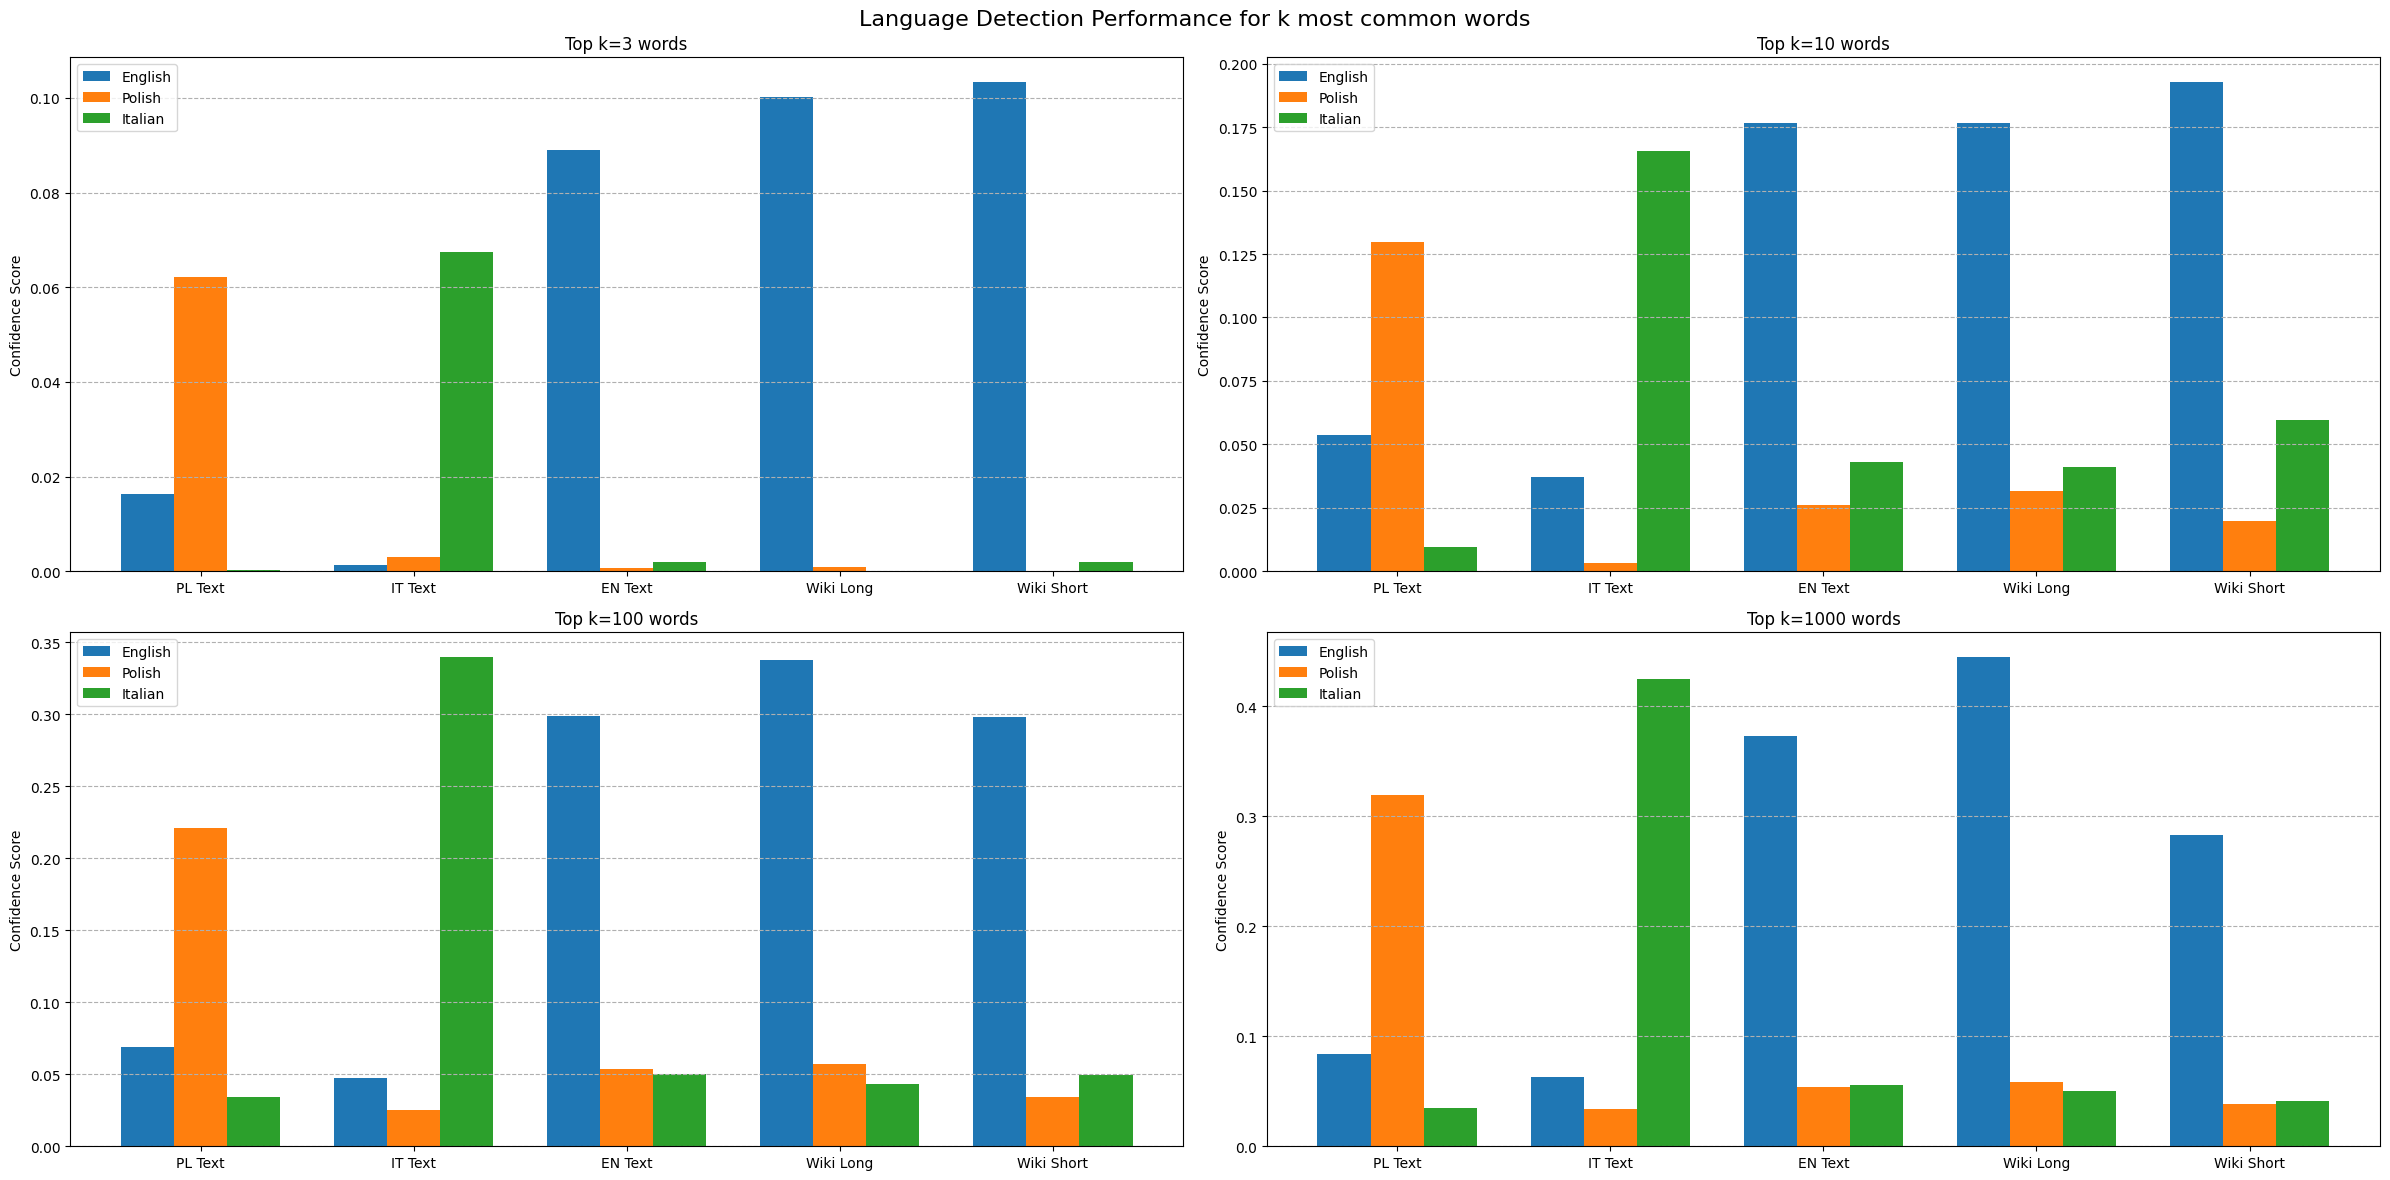

In [67]:
text_labels = [
    "PL Text",
    "IT Text",
    "EN Text",
    "Wiki Long",
    "Wiki Short"
]

fig, axs = plt.subplots(2, 2, figsize=(24, 12))
axs = axs.flatten()

x = np.arange(len(text_labels))
width = 0.25

for i, k in enumerate(K):
    ax = axs[i]

    # get results for specific k
    scores_en = results[i][0]
    scores_pl = results[i][1]
    scores_it = results[i][2]

    ax.bar(x - width, scores_en, width, label='English')
    ax.bar(x,         scores_pl, width, label='Polish')
    ax.bar(x + width, scores_it, width, label='Italian')

    ax.set_title(f'Top k={k} words')
    ax.set_ylabel('Confidence Score')
    ax.set_xticks(x)

    ax.set_xticklabels(text_labels)

    ax.grid(axis='y', linestyle='--')

    ax.legend(loc='upper left')

fig.suptitle(
    'Language Detection Performance for k most common words', fontsize=16)

plt.tight_layout()
plt.show()

# Summary and Conclusions

* **Algorithm Effectiveness:** The proposed `lang_confidence_score` function works correctly, showing a visible margin between the score for the correct language and the others.
* **Impact of `k`:** With a larger `k`, the scores for incorrect languages increase significantly (though they remain lower than the target language). This is likely due to short, common words like "on", "a", "to", etc., that occur in a lot of languages.
* **Short Article Anomaly:** Surprisingly, the short Wiki article achieves its highest score with a small `k`, and this score decreases as `k` increases. This suggests that the short text is densely packed with the absolute most frequent English words (top 10-100), which dominate the intersection early on, but its vocabulary is various enough to continue with the reference model as the range `k` expands.
* **Best Differentiation:** The clearest distinction in confidence scores was observed in the **Italian article**, which likely indicates that it has the biggest variety of vocabulary.

---
#### Did the choice of languages make a difference?

Yes. Since all selected languages share the same **Latin alphabet**, there is an inherent overlap in character sets and occasional words that look the same but have different meanings (mostly short words). Furthermore, the fact that all selected languages are European increases the likelihood of shared worsd compared to non-European languages.

---
#### Is it possible to deduce the degree of inflection in language?

It is evident that the `lang_confidence_score` function was least confident regarding the **Polish** language. This is directly caused by **word inflection**.
Although Italian is also more inflected than English, the difference between them was not as significant as with Polish. We can conclude that while highly inflected languages (like Polish) are easily detectable by a lower score in this metric, moderately inflected languages might not show a drastic difference compared to non-inflected ones.

---
#### Is it difficult to find a Wiki article with a low score?

Yes, it is difficult. Even extremely short articles (like "Sun Flute") contain enough frequent English frequent words to make the function highly confident in the language detection.
However, this dynamic would likely change if the short article were written in **Polish** or **Italian**. As observed in the plots, the confidence for these languages rises more dynamically as `k` increases, suggesting they require a larger vocabulary match to achieve high confidence compared to English.